In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d
import ssm.hmm as hmm

save_figures = False

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from NetFormer import tools, data

In [3]:
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.size': 14
})

## Process Neural Data

In [ ]:
input_mouse = ['SB025']
input_sessions = [['2019-10-23']]

window_size = 60
split_ratio = 0.8

directory = '../../data/Mouse/Bugeon/'
input_sessions_file_path = []
for i in range(len(input_mouse)):
    for j in range(len(input_sessions[i])):
        input_sessions_file_path.append({'date_exp': input_mouse[i] + '/' + input_sessions[i][j] + '/', 'input_setting': 'Blank/01/'})
        print(input_mouse[i] + '/' + input_sessions[i][j])

all_sessions_original_UniqueID = []
all_sessions_original_cell_type = []

all_sessions_acitvity_TRAIN = []   # first 80% of the time
all_sessions_acitvity_TEST = []

all_sessions_state_TRAIN = []
all_sessions_state_TEST = []

num_neurons_per_session = []
sessions_2_original_cell_type = []
all_sessions_activity_flatten = []

for i in range(len(input_sessions_file_path)):
    date_exp = input_sessions_file_path[i]['date_exp']
    input_setting = input_sessions_file_path[i]['input_setting']
    activity, frame_states, frame_times, UniqueID, neuron_ttypes = data.load_mouse_data_session(
        directory, date_exp, input_setting, normalization="no"
    )
    frame_states = frame_states.flatten()

    all_sessions_original_UniqueID.append(UniqueID)
    all_sessions_acitvity_TRAIN.append(activity[:, :int(activity.shape[1]*split_ratio)])
    all_sessions_acitvity_TEST.append(activity[:, int(activity.shape[1]*split_ratio):])
    all_sessions_state_TRAIN.append(frame_states[:int(activity.shape[1]*split_ratio)])
    all_sessions_state_TEST.append(frame_states[int(activity.shape[1]*split_ratio):])
    num_neurons_per_session.append(activity.shape[0])
    all_sessions_activity_flatten.append(activity.flatten())

    # Get the first level of cell types
    neuron_types_result = []
    for j in range(len(neuron_ttypes)):
        # split by "-"
        neuron_types_result.append(neuron_ttypes[j].split("-")[0])

    sessions_2_original_cell_type.append(neuron_types_result)
    all_sessions_original_cell_type.append(neuron_types_result)

all_sessions_original_UniqueID = np.concatenate(all_sessions_original_UniqueID)
all_sessions_original_cell_type = np.concatenate(all_sessions_original_cell_type)
all_sessions_activity_flatten = np.concatenate(all_sessions_activity_flatten)
mu = np.mean(all_sessions_activity_flatten)
std = np.std(all_sessions_activity_flatten)

# all_sessions normalization
all_sessions_acitvity_TRAIN = [(session - mu) / std for session in all_sessions_acitvity_TRAIN]
all_sessions_acitvity_TEST = [(session - mu) / std for session in all_sessions_acitvity_TEST]

##############################################
# Construct new UniqueID and cell type id
##############################################

all_sessions_new_UniqueID, num_unqiue_neurons = tools.assign_unique_neuron_ids(all_sessions_original_UniqueID, num_neurons_per_session)
all_sessions_new_cell_type_id, cell_type_order = tools.assign_unique_cell_type_ids(all_sessions_original_cell_type, num_neurons_per_session)

neuron_id_2_cell_type_id = np.zeros((num_unqiue_neurons,)).astype(int)
for i in range(len(all_sessions_new_UniqueID)):
    neuron_id_2_cell_type_id[all_sessions_new_UniqueID[i].astype(int)] = all_sessions_new_cell_type_id[i]

SB025/2019-10-23
no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']


In [ ]:
neural_data = all_sessions_acitvity_TRAIN[0]
neural_data = neural_data.T

state = all_sessions_state_TRAIN[0]
state = state.astype(int)

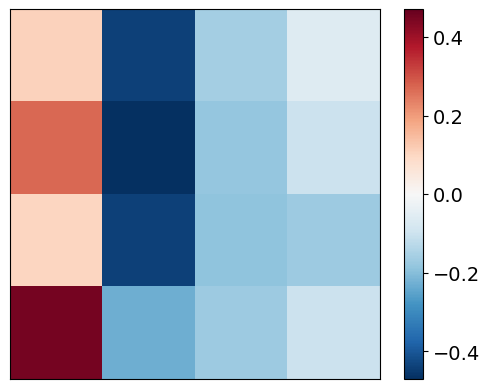

In [ ]:
eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']

KK_GT = np.zeros((4, 4))
KK_GT[0, 0] = 0.11
KK_GT[1, 0] = 0.27
KK_GT[2, 0] = 0.1
KK_GT[3, 0] = 0.45

KK_GT[0, 1] = -0.44
KK_GT[1, 1] = -0.47
KK_GT[2, 1] = -0.44
KK_GT[3, 1] = -0.23

KK_GT[0, 2] = -0.16
KK_GT[1, 2] = -0.18
KK_GT[2, 2] = -0.19
KK_GT[3, 2] = -0.17

KK_GT[0, 3] = -0.06
KK_GT[1, 3] = -0.10
KK_GT[2, 3] = -0.17
KK_GT[3, 3] = -0.10

max_abs = np.max(np.abs(KK_GT))
vmin_KK = -max_abs
vmax_KK = max_abs

plt.imshow(KK_GT, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Train arHMM

In [ ]:
# Set the parameters of the arHMM and SLDS
time_bins = 3154    # number of time bins
n_disc_states = 3       # number of discrete states
latent_dim = 527       # number of latent dimensions
emissions_dim = 527      # number of observed dimensions

N_iters = 50
arhmm = hmm.HMM(
    K=n_disc_states, D=latent_dim, observations="ar"
)

arhmm_lls = arhmm.fit(neural_data, method="em", num_iters=N_iters, init_method="kmeans")
most_likely_states = arhmm.most_likely_states(neural_data)

arhmm.permute(find_permutation(state, most_likely_states))
most_likely_states = arhmm.most_likely_states(neural_data)

## Evaluate arHMM

In [ ]:
arHMM_W = arhmm.observations.As
arHMM_state = most_likely_states

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(211)
plt.plot(arHMM_state, 'black', linewidth=1)
names = ['running', 'stationary sync', 'stationary desync']
plt.yticks([0, 1, 2], names, fontsize=12)
plt.title('AR-HMM inferred states')

plt.subplot(212)
plt.plot(state, 'black', linewidth=1)
plt.yticks([0, 1, 2], names, fontsize=12)
plt.title('true states')

plt.tight_layout()
plt.show()

corr_strength_KK: 0.16690515261654337
spearman_corr_strength_KK: 0.21518107116515492


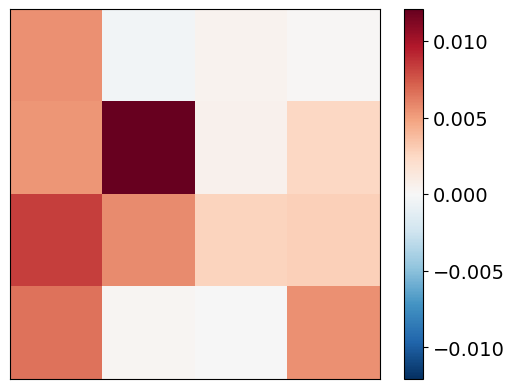

In [ ]:
state0_KK_strength = tools.multisession_NN_to_KK(
    [arHMM_W[0]],
    cell_type_order,
    all_sessions_new_cell_type_id,
)
state0_KK_strength = tools.experiment_KK_to_eval_KK(state0_KK_strength, cell_type_order, eval_cell_type_order)

corr_strength_KK = stats.pearsonr(KK_GT.flatten(), state0_KK_strength.flatten())[0]
spearman_corr_strength_KK = stats.spearmanr(KK_GT.flatten(), state0_KK_strength.flatten())[0]
print('corr_strength_KK:', corr_strength_KK)
print('spearman_corr_strength_KK:', spearman_corr_strength_KK)

plt.imshow(state0_KK_strength, cmap='RdBu_r', interpolation="nearest", vmin=-np.max(np.abs(state0_KK_strength)), vmax=np.max(np.abs(state0_KK_strength)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

corr_strength_KK: -0.32502110110587334
spearman_corr_strength_KK: -0.20339032753966696


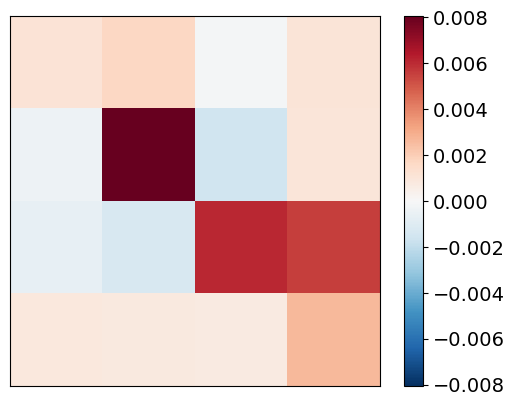

In [ ]:
state1_KK_strength = tools.multisession_NN_to_KK(
    [arHMM_W[1]],
    cell_type_order,
    all_sessions_new_cell_type_id,
)
state1_KK_strength = tools.experiment_KK_to_eval_KK(state1_KK_strength, cell_type_order, eval_cell_type_order)

corr_strength_KK = stats.pearsonr(KK_GT.flatten(), state1_KK_strength.flatten())[0]
spearman_corr_strength_KK = stats.spearmanr(KK_GT.flatten(), state1_KK_strength.flatten())[0]
print('corr_strength_KK:', corr_strength_KK)
print('spearman_corr_strength_KK:', spearman_corr_strength_KK)

plt.imshow(state1_KK_strength, cmap='RdBu_r', interpolation="nearest", vmin=-np.max(np.abs(state1_KK_strength)), vmax=np.max(np.abs(state1_KK_strength)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

corr_strength_KK: 0.14295913592141143
spearman_corr_strength_KK: 0.14443660941222727


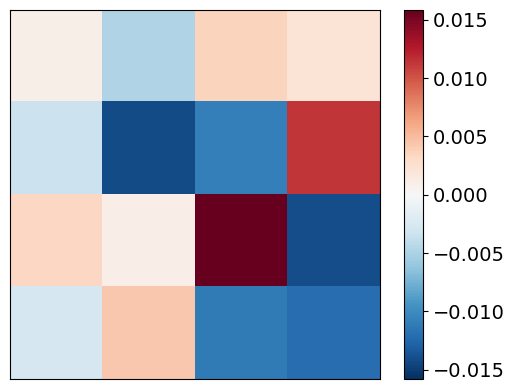

In [ ]:
state2_KK_strength = tools.multisession_NN_to_KK(
    [arHMM_W[2]],
    cell_type_order,
    all_sessions_new_cell_type_id,
)
state2_KK_strength = tools.experiment_KK_to_eval_KK(state2_KK_strength, cell_type_order, eval_cell_type_order)

corr_strength_KK = stats.pearsonr(KK_GT.flatten(), state2_KK_strength.flatten())[0]
spearman_corr_strength_KK = stats.spearmanr(KK_GT.flatten(), state2_KK_strength.flatten())[0]
print('corr_strength_KK:', corr_strength_KK)
print('spearman_corr_strength_KK:', spearman_corr_strength_KK)

plt.imshow(state2_KK_strength, cmap='RdBu_r', interpolation="nearest", vmin=-np.max(np.abs(state2_KK_strength)), vmax=np.max(np.abs(state2_KK_strength)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

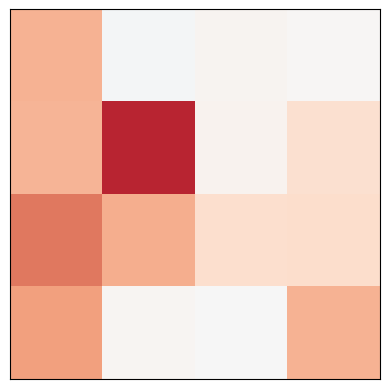

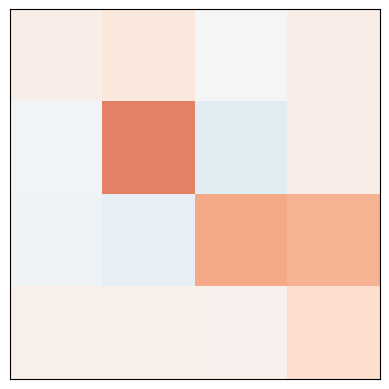

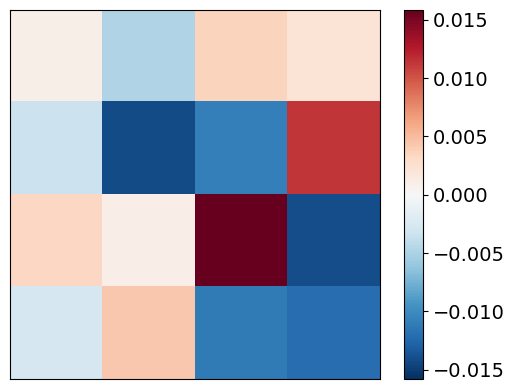

In [36]:
# get one vmin and vmax for all states
max_abs = np.max(np.abs([state0_KK_strength, state1_KK_strength, state2_KK_strength]))
vmin_KK = -max_abs
vmax_KK = max_abs

plt.imshow(state0_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(state1_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(state2_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()